In [ ]:
import kagglehub

path = kagglehub.dataset_download("bmadushanirodrigo/fracture-multi-region-x-ray-data")

print("Path to dataset files:", path)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D,BatchNormalization,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from sklearn.model_selection import train_test_split
import os
import cv2
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, UnidentifiedImageError
import shutil
from shutil import copyfile
import plotly.express as px

In [ ]:
train=path+'/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'
test=path+'/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'
val=path+'/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val'

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
os.listdir(train_dir)

In [ ]:
import glob
img_size = []

for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    image_paths = glob.glob(os.path.join(folder_path, '*'))

    for img_path in image_paths:
        try:
            img = plt.imread(img_path)
            img_size.append(img.shape)
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")

In [ ]:
pd.Series(img_size).value_counts()

In [ ]:
pd.Series(img_size).min()

In [ ]:
def count_images(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

print("Train:", count_images(train_dir))
print("Val:", count_images(val_dir))
print("Test:", count_images(test_dir))

In [ ]:

train_gen=ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_gen=ImageDataGenerator(rescale=1./255)
valid_gen=ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen=ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_gen=ImageDataGenerator(rescale=1./255)
valid_gen=ImageDataGenerator(rescale=1./255)

train_data=train_gen.flow_from_directory(
    train,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical', # Changed back to categorical
    shuffle=True,
)
test_data=test_gen.flow_from_directory(
    test,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical', # Changed back to categorical
)
valid_data=valid_gen.flow_from_directory(
    val,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical', # Changed back to categorical
)

In [ ]:
train_data.class_indices

In [ ]:
train_data.image_shape

In [ ]:
len(train)

In [ ]:
class_labels = {v: k for k, v in train_data.class_indices.items()}
class_labels

In [ ]:
fractured_dir = os.path.join(train, 'fractured')
fractured_images = os.listdir(fractured_dir)

In [ ]:

import matplotlib.image as mpimg

plt.figure(figsize=(10, 10))
for i in range(min(9, len(fractured_images))):
    img_path = os.path.join(fractured_dir, fractured_images[i])
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title("Fractured", fontsize=10)
    plt.axis('off')
plt.suptitle("Sample Fractured Images", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
not_fractured_dir = os.path.join(train, 'not fractured')
not_fractured_images = os.listdir(not_fractured_dir)

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(min(9, len(not_fractured_images))):
    img_path = os.path.join(not_fractured_dir, not_fractured_images[i])
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title("Not Fractured", fontsize=10)
    plt.axis('off')
plt.suptitle("Sample Not Fractured Images", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
fracture_imgs_dict = {
    'fractured': os.listdir(os.path.join(train, 'fractured')),
    'not fractured': os.listdir(os.path.join(train, 'not fractured'))
}

In [ ]:
fracture_labels = {
    'fractured': 1,
    'not fractured': 0
}

In [ ]:
n_fractured = len(fracture_imgs_dict['fractured'])
n_not_fractured = len(fracture_imgs_dict['not fractured'])

In [ ]:
n_images = [n_fractured, n_not_fractured]
px.pie(names=['fractured', 'not fractured'], values=n_images, title='Fracture Data Distribution').show()

In [ ]:
from PIL import Image, UnidentifiedImageError
import os

def remove_truncated_images(directory):
    removed = 0
    for subdir, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    img.load()
            except (UnidentifiedImageError, OSError, ValueError) as e:
                print(f"Deleting corrupted image: {file_path} - {e}")
                os.remove(file_path)
                removed += 1
    return removed

removed_train = remove_truncated_images(train)
removed_val = remove_truncated_images(val)
removed_test = remove_truncated_images(test)

print(f"Removed {removed_train} corrupted images from training set.")
print(f"Removed {removed_val} corrupted images from validation set.")
print(f"Removed {removed_test} corrupted images from test set.")

In [ ]:
img_sizes = []
for file in os.listdir(fractured_dir):
    img = plt.imread(os.path.join(fractured_dir, file))
    img_sizes.append(img.shape)

In [ ]:
pd.Series(img_sizes).value_counts()

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [ ]:
input_shape = (224, 224, 3)

In [342]:
xception_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
for layer in xception_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model=Sequential()

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding = 'same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding = 'same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding = 'same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))

model.add(Dense(2,activation='softmax'))
model.summary()

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [346]:
history=model.fit(train_data,validation_data=valid_data,epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.6132 - loss: 0.6468

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



289/289 ━━━━━━━━━━━━━━━━━━━━ 171s 576ms/step - accuracy: 0.6134 - loss: 0.6466 - val_accuracy: 0.5935 - val_loss: 1.0937
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 144s 496ms/step - accuracy: 0.7424 - loss: 0.5242 - val_accuracy: 0.7636 - val_loss: 0.5213
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 197s 478ms/step - accuracy: 0.7969 - loss: 0.4364 - val_accuracy: 0.6634 - val_loss: 0.7210
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 138s 478ms/step - accuracy: 0.8392 - loss: 0.3629 - val_accuracy: 0.8058 - val_loss: 0.4268
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 138s 476ms/step - accuracy: 0.8796 - loss: 0.2891 - val_accuracy: 0.7877 - val_loss: 0.5533
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 143s 494ms/step - accuracy: 0.9104 - loss: 0.2234 - val_accuracy: 0.4475 - val_loss: 1.0031
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 138s 477ms/step - accuracy: 0.9249 - loss: 0.1882 - val_accuracy: 0.8203 - val_loss: 0.4314
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 140s 483ms/step - accuracy: 0.9373 - loss: 0.15

In [347]:
model.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - accuracy: 0.9310 - loss: 0.2007


[0.21232837438583374, 0.9169960618019104]

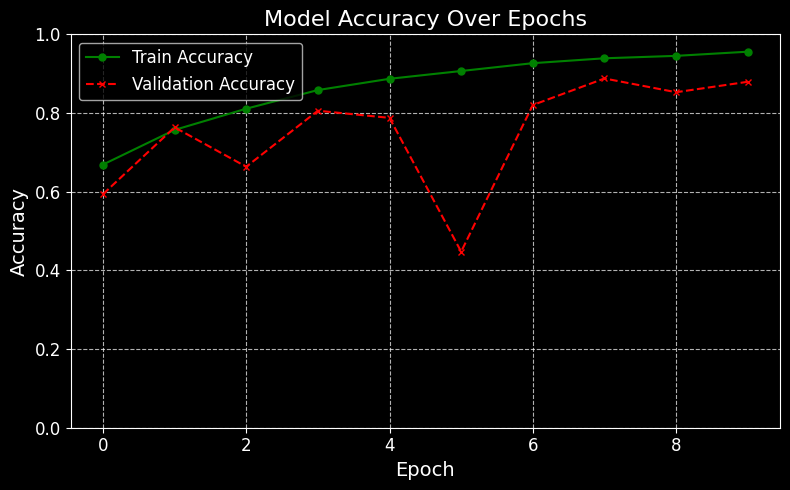

In [348]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], color='green', linestyle='-', marker='o', markersize=5, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Accuracy')

plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.ylim(0, 1)

plt.tight_layout()
plt.show()

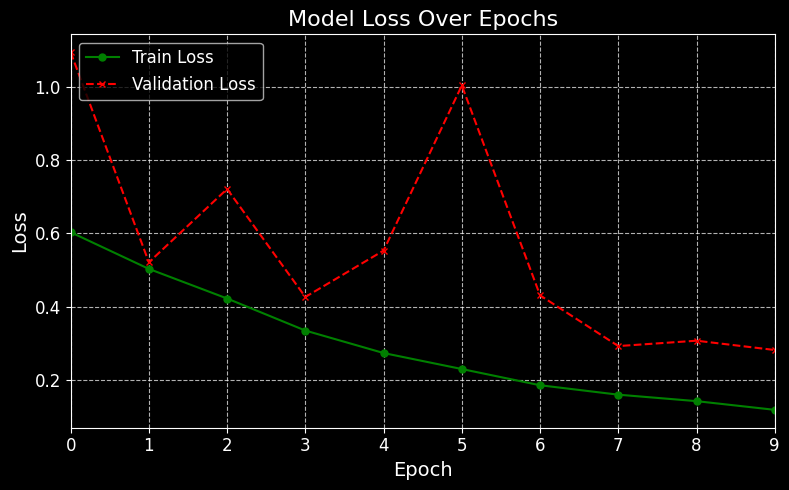

In [349]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='green', linestyle='-', marker='o', markersize=5, label='Train Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Loss')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()

In [350]:
model.save('xception_bonefracture_v1.h5')

In [351]:
load_model=tf.keras.models.load_model('xception_bonefracture_v1.h5')

Randomly selected image: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/5-rotated1-rotated1-rotated3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


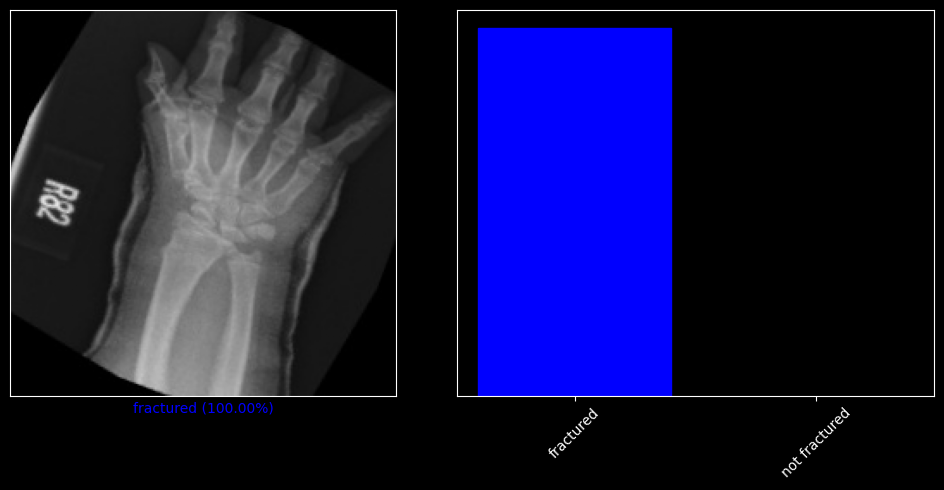

In [352]:
from tensorflow.keras.preprocessing import image

# Select either val_dir or test_dir
img_base_dir = val_dir  # Or test_dir

# Get all class subdirectories (e.g., 'fractured', 'not fractured')
class_names = sorted(os.listdir(img_base_dir))

# Choose a random class and image
random_class = random.choice(class_names)
class_path = os.path.join(img_base_dir, random_class)
img_filename = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_filename)

print(f"Randomly selected image: {img_path}")

# Load and preprocess image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

img = preprocess_image(img_path)

# Make prediction
predictions = model.predict(img)
true_label = class_names.index(random_class)

# Visualization functions
def plot_image(predictions_array, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    color = 'blue' if predicted_label == true_label else 'red'

    plt.xlabel(
        f"{class_names[predicted_label]} ({100*np.max(predictions_array):.2f}%)",
        color=color
    )

def plot_value_array(predictions_array, true_label, class_names):
    plt.grid(False)
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks([])

    bars = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    bars[np.argmax(predictions_array)].set_color('red')
    bars[true_label].set_color('blue')

# Plot image and prediction
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_image(predictions[0], true_label, img[0], class_names)

plt.subplot(1, 2, 2)
plot_value_array(predictions[0], true_label, class_names)

plt.tight_layout()
plt.show()

Randomly selected image: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


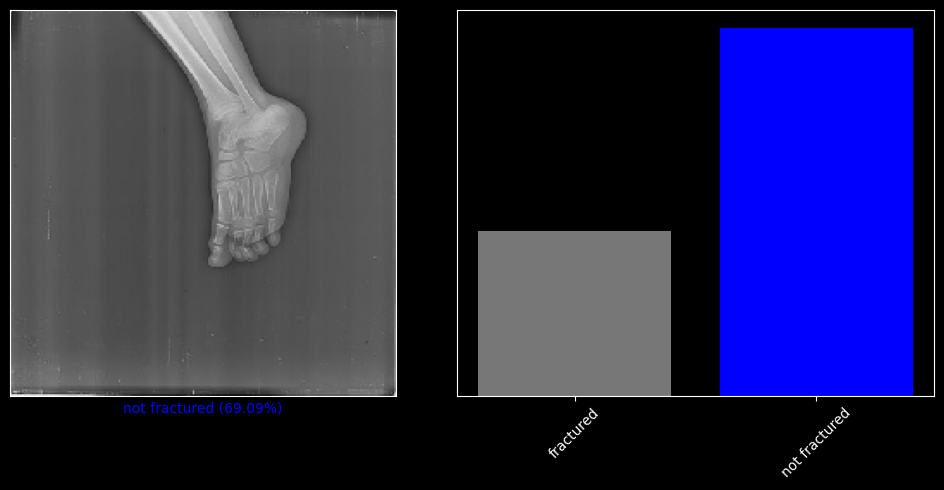

In [353]:
from tensorflow.keras.preprocessing import image

# Select either val_dir or test_dir
img_base_dir = val_dir  # Or test_dir

# Get all class subdirectories (e.g., 'fractured', 'not fractured')
class_names = sorted(os.listdir(img_base_dir))

# Choose a random class and image
random_class = random.choice(class_names)
class_path = os.path.join(img_base_dir, random_class)
img_filename = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_filename)

print(f"Randomly selected image: {img_path}")

# Load and preprocess image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

img = preprocess_image(img_path)

# Make prediction
predictions = model.predict(img)
true_label = class_names.index(random_class)

# Visualization functions
def plot_image(predictions_array, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    color = 'blue' if predicted_label == true_label else 'red'

    plt.xlabel(
        f"{class_names[predicted_label]} ({100*np.max(predictions_array):.2f}%)",
        color=color
    )

def plot_value_array(predictions_array, true_label, class_names):
    plt.grid(False)
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks([])

    bars = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    bars[np.argmax(predictions_array)].set_color('red')
    bars[true_label].set_color('blue')

# Plot image and prediction
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_image(predictions[0], true_label, img[0], class_names)

plt.subplot(1, 2, 2)
plot_value_array(predictions[0], true_label, class_names)

plt.tight_layout()
plt.show()

In [354]:
scratch_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(2, activation='softmax')  # For 2 classes
])
scratch_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_108 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,146,882 (99.74 MB)

 Trainable params: 26,145,922 (99.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [355]:
scratch_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [356]:
scratch_history = scratch_model.fit(
    train_data,
    epochs=10,
    validation_data=valid_data,
    verbose=1
)

Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.6073 - loss: 1.2169

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



289/289 ━━━━━━━━━━━━━━━━━━━━ 138s 456ms/step - accuracy: 0.6074 - loss: 1.2160 - val_accuracy: 0.6357 - val_loss: 0.6876
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 126s 435ms/step - accuracy: 0.6858 - loss: 0.7066 - val_accuracy: 0.7551 - val_loss: 0.5084
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 142s 436ms/step - accuracy: 0.7286 - loss: 0.5901 - val_accuracy: 0.8058 - val_loss: 0.4954
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 439ms/step - accuracy: 0.7707 - loss: 0.5061 - val_accuracy: 0.8263 - val_loss: 0.4474
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 126s 436ms/step - accuracy: 0.8076 - loss: 0.4588 - val_accuracy: 0.8215 - val_loss: 0.4385
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 131s 454ms/step - accuracy: 0.8181 - loss: 0.4121 - val_accuracy: 0.6767 - val_loss: 0.7862
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 126s 437ms/step - accuracy: 0.8362 - loss: 0.3773 - val_accuracy: 0.8408 - val_loss: 0.4521
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 127s 440ms/step - accuracy: 0.8412 - loss: 0.36

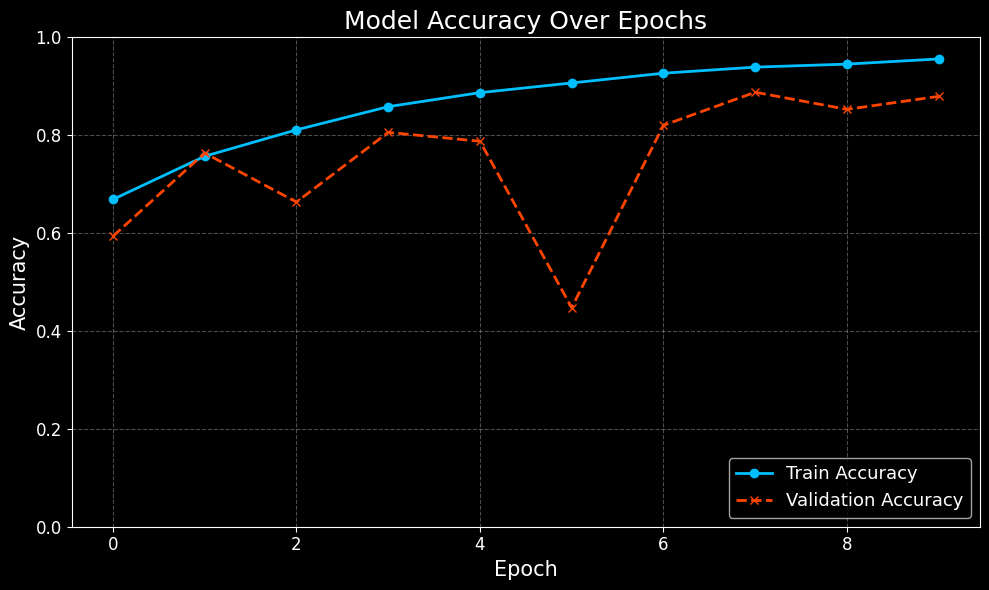

In [357]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')  # Dark theme

plt.figure(figsize=(10, 6))  # Bigger figure

# Plotting
plt.plot(history.history['accuracy'],
         color='#00BFFF', linestyle='-', marker='o', markersize=6, linewidth=2,
         label='Train Accuracy')  # DeepSkyBlue

plt.plot(history.history['val_accuracy'],
         color='#FF4500', linestyle='--', marker='x', markersize=6, linewidth=2,
         label='Validation Accuracy')  # OrangeRed

# Titles and labels
plt.title('Model Accuracy Over Epochs', fontsize=18, color='white')
plt.xlabel('Epoch', fontsize=15, color='white')
plt.ylabel('Accuracy', fontsize=15, color='white')
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='lower right', fontsize=13)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

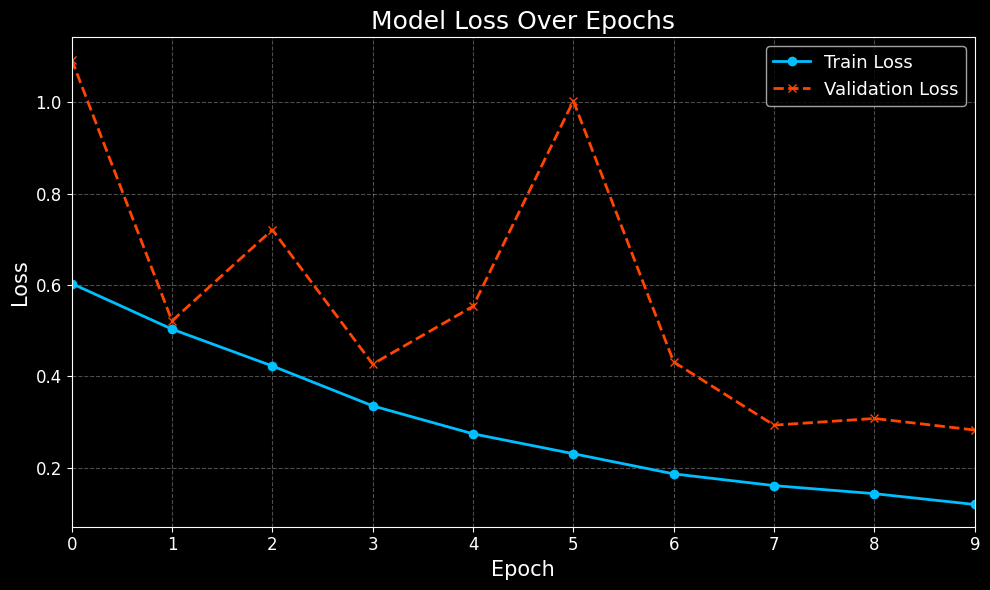

In [358]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')  # Apply dark theme

plt.figure(figsize=(10, 6))

# Plot Loss
plt.plot(history.history['loss'],
         color='#00BFFF', linestyle='-', marker='o', markersize=6, linewidth=2,
         label='Train Loss')  # Blue tone

plt.plot(history.history['val_loss'],
         color='#FF4500', linestyle='--', marker='x', markersize=6, linewidth=2,
         label='Validation Loss')  # Red-orange tone

# Titles and Labels
plt.title('Model Loss Over Epochs', fontsize=18, color='white')
plt.xlabel('Epoch', fontsize=15, color='white')
plt.ylabel('Loss', fontsize=15, color='white')
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper right', fontsize=13)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()

In [359]:
scratch_model.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - accuracy: 0.8323 - loss: 0.3424


[0.3314497768878937, 0.8280632495880127]

In [360]:
scratch_model.save('scratch_bonefracture_v1.h5')

In [361]:
scratch_model=tf.keras.models.load_model('scratch_bonefracture_v1.h5')

Randomly selected image: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/13-rotated3-rotated3-rotated1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


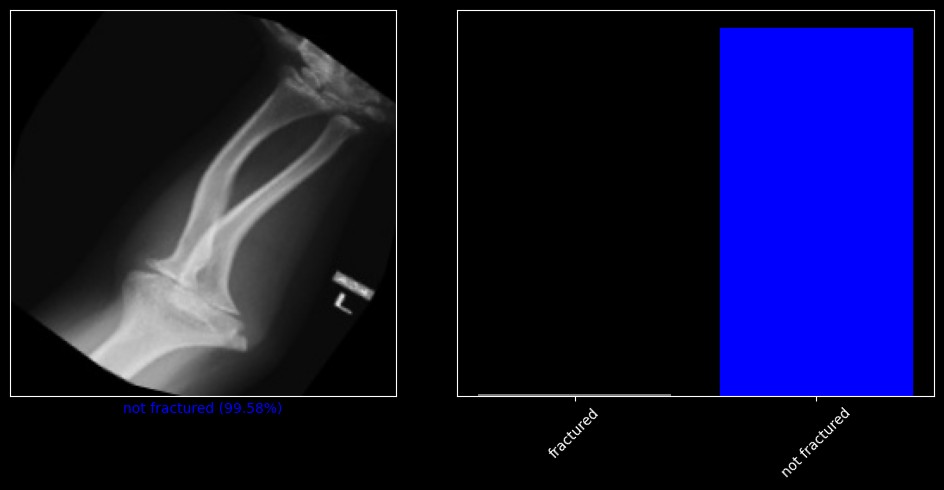

In [362]:
# Select either val_dir or test_dir
img_base_dir = val_dir  # Or test_dir

# Get all class subdirectories (e.g., 'fractured', 'not fractured')
class_names = sorted(os.listdir(img_base_dir))

# Choose a random class and image
random_class = random.choice(class_names)
class_path = os.path.join(img_base_dir, random_class)
img_filename = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_filename)

print(f"Randomly selected image: {img_path}")

# Load and preprocess image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

img = preprocess_image(img_path)

# Make prediction
predictions = scratch_model.predict(img)
true_label = class_names.index(random_class)

# Visualization functions
def plot_image(predictions_array, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    color = 'blue' if predicted_label == true_label else 'red'

    plt.xlabel(
        f"{class_names[predicted_label]} ({100*np.max(predictions_array):.2f}%)",
        color=color
    )

def plot_value_array(predictions_array, true_label, class_names):
    plt.grid(False)
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks([])

    bars = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    bars[np.argmax(predictions_array)].set_color('red')
    bars[true_label].set_color('blue')

# Plot image and prediction
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_image(predictions[0], true_label, img[0], class_names)

plt.subplot(1, 2, 2)
plot_value_array(predictions[0], true_label, class_names)

plt.tight_layout()
plt.show()

Randomly selected image: /kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/image12.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


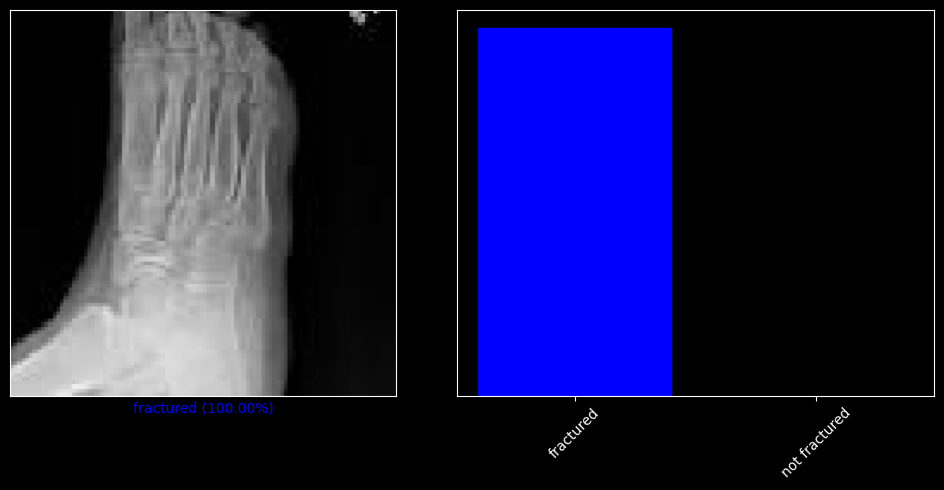

In [363]:
# Select either val_dir or test_dir
img_base_dir = val_dir  # Or test_dir

# Get all class subdirectories (e.g., 'fractured', 'not fractured')
class_names = sorted(os.listdir(img_base_dir))

# Choose a random class and image
random_class = random.choice(class_names)
class_path = os.path.join(img_base_dir, random_class)
img_filename = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_filename)

print(f"Randomly selected image: {img_path}")

# Load and preprocess image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

img = preprocess_image(img_path)

# Make prediction
predictions = scratch_model.predict(img)
true_label = class_names.index(random_class)

# Visualization functions
def plot_image(predictions_array, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    color = 'blue' if predicted_label == true_label else 'red'

    plt.xlabel(
        f"{class_names[predicted_label]} ({100*np.max(predictions_array):.2f}%)",
        color=color
    )

def plot_value_array(predictions_array, true_label, class_names):
    plt.grid(False)
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks([])

    bars = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    bars[np.argmax(predictions_array)].set_color('red')
    bars[true_label].set_color('blue')

# Plot image and prediction
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_image(predictions[0], true_label, img[0], class_names)

plt.subplot(1, 2, 2)
plot_value_array(predictions[0], true_label, class_names)

plt.tight_layout()
plt.show()